# 프로젝트 : 한영 번역기 만들기

## 1. 데이터 정제

In [1]:
# 한글폰트 적용

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [2]:
# 모듈 import

import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.4.1


In [3]:
# 데이터 불러오기

path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/train/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    train_ko_raw = f.read().splitlines()

print("Data Size:", len(train_ko_raw))

print("Example:")
for sen_ko in train_ko_raw[0:100][::20]: print(">>", sen_ko)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [4]:
path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/train/korean-english-park.train.en'

with open(path_to_file, "r") as f:
    train_en_raw = f.read().splitlines()

print("Data Size:", len(train_en_raw))

print("Example:")
for sen_en in train_en_raw[0:100][::20]: print(">>", sen_en)
    

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [5]:
# 데이터 전처리

cleaned_corpus = list(set(zip(train_ko_raw, train_en_raw)))

cleaned_corpus = cleaned_corpus[:30000]

cleaned_corpus_ko = []
cleaned_corpus_en = []

for i in range(len(cleaned_corpus)):
    cleaned_corpus_ko.append(sen_ko)
    
for i in range(len(cleaned_corpus)):
    cleaned_corpus_en.append(sen_en)
    
for sen_ko, sen_en in zip(cleaned_corpus_ko[:100:20], cleaned_corpus_en[:100:20]):
    print(">>", sen_ko , sen_en)
    
    
print(len(cleaned_corpus))
print(len(cleaned_corpus_ko))
print(len(cleaned_corpus_en))

>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다. Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다. Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다. Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of w

In [6]:
# 한글적용 가능한 preprocessing

from konlpy.tag import Mecab
tokenizer = Mecab()

def preprocess_sentence_ko(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 a-z A-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    sentence = tokenizer.morphs(sentence)
    
    return sentence

def preprocess_sentence_en(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 a-z A-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    sentence = sentence.split()
    
    return sentence

In [7]:
corpus_list = list(cleaned_corpus)
len(corpus_list)

30000

In [8]:
# 길이를 제한한 데이터로 corpus 구축

# max_len = 40

enc_corpus = []
dec_corpus = []

for sen_ko, sen_en in zip(cleaned_corpus_ko, cleaned_corpus_en):
#     if len(sen_ko) <= max_len:
    enc_corpus.append(preprocess_sentence_ko(sen_ko))
    dec_corpus.append(preprocess_sentence_en(sen_en, s_token=True, e_token=True))

print(len(enc_corpus))
print(len(dec_corpus))
print("Korean:", enc_corpus[100])   
print("English:", dec_corpus[100])

30000
30000
Korean: ['또한', '근력', '운동', '은', '활발', '하', '게', '걷', '는', '것', '이나', '최소', '한', '분', '동안', '뛰', '는', '것', '과', '같', '은', '유산소', '활동', '에서', '얻', '는', '운동', '효과', '를', '심장', '과', '폐', '에', '주', '지', '않', '기', '때문', '에', ',', '연구', '학자', '들', '은', '근력', '운동', '이', '심장', '에', '큰', '영향', '을', '미치', '는지', '여부', '에', '대해', '논쟁', '을', '해', '왔', '다', '.']
English: ['<start>', 'researchers', 'also', 'have', 'debated', 'whether', 'weight', 'training', 'has', 'a', 'big', 'impact', 'on', 'the', 'heart', ',', 'since', 'it', 'does', 'not', 'give', 'the', 'heart', 'and', 'lungs', 'the', 'kind', 'of', 'workout', 'they', 'get', 'from', 'aerobic', 'activities', 'such', 'as', 'brisk', 'walking', 'or', 'running', 'for', 'at', 'least', 'minutes', '.', '<end>']


In [9]:
# 데이터 토큰화

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer


enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

enc_train = enc_tensor
dec_train = dec_tensor

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 49
English Vocab Size: 43


## 2. 모델 설계

In [10]:
# Bahdanau Attention

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [11]:
# Encoder

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [12]:
# Decoder

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [13]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 # 예: len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1 # 예: len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 1024)
Decoder Output: (64, 44)
Decoder Hidden State: (64, 1024)
Attention: (64, 40, 1)


## 3. 훈련하기

In [14]:
# Optimaizer & Loss

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [15]:
# train_step함수 생성

@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [16]:
# 훈련 시작

from tqdm import tqdm
import random 

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

Epoch 10: 100%|██████████| 469/469 [36:09<00:00,  4.63s/it, Loss 0.0000]


In [17]:
# 훈련 모델 평가

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence_ko(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split())

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: researchers also have debated whether weight training has a big impact on the heart and lungs the heart and lungs the heart and lungs the heart and lungs the heart and lungs the heart and lungs the heart and lungs the heart and lungs the heart 


/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator


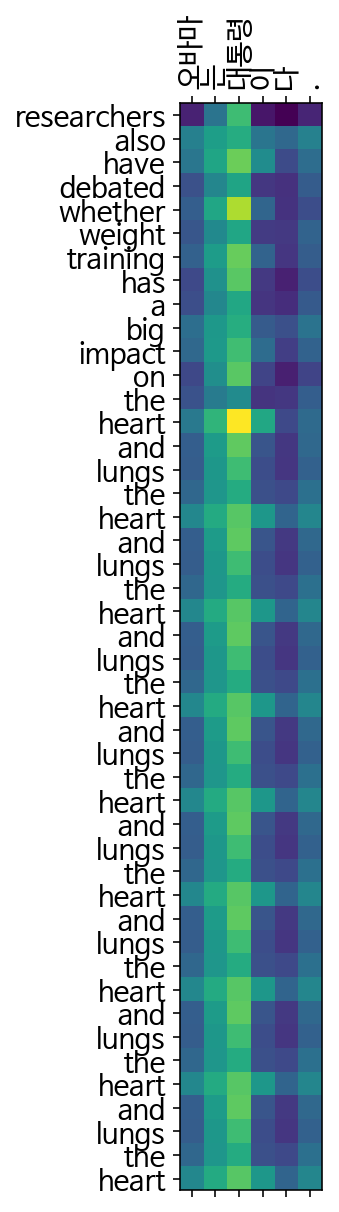

In [18]:

translate("오바마는 대통령이다.", encoder, decoder)

Input: ['나', '는', '강아지', '를', '키운다', '.']
Predicted translation: researchers also have debated whether weight training has a big impact on the heart and lungs the heart and lungs the heart and lungs the heart and lungs the heart and lungs the heart and lungs the heart and lungs the heart and lungs the heart 


/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator


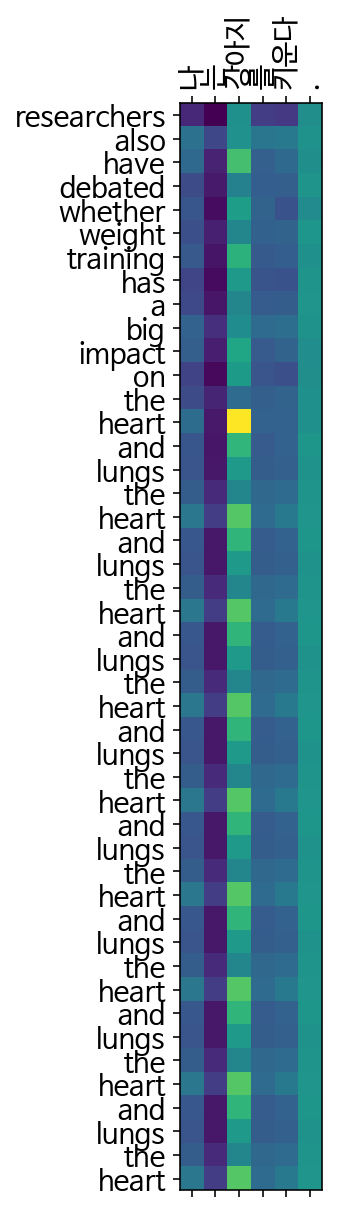

In [19]:
translate("나는 강아지를 키운다.", encoder, decoder)